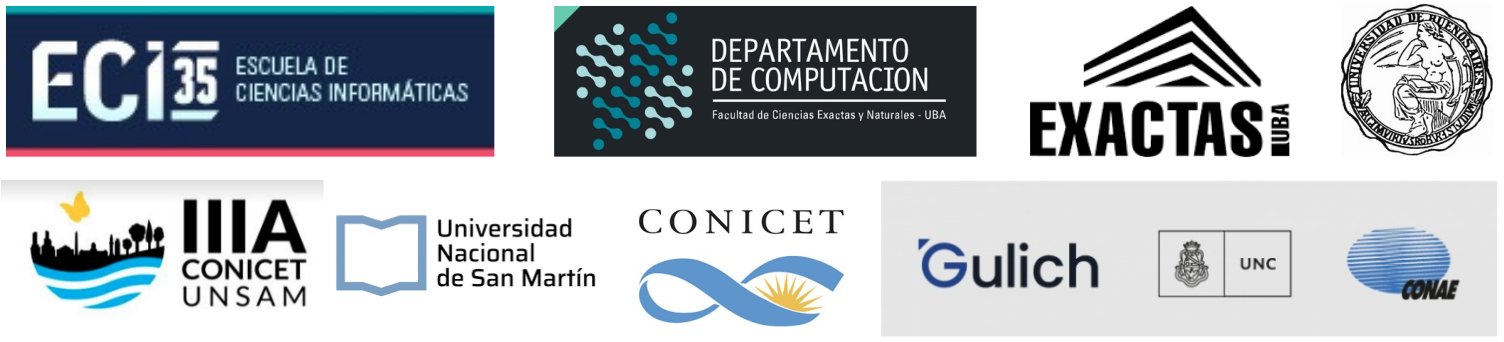
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 9: Análisis exploratorio de datos
---
Lo que veremos en esta notebook:

- [x] Imágenes (no satelitales). Las imágenes expresadas como array
- [x] Representación de una imagen en niveles de gris
- [x] Resolución de una imagen
---
Rasterio
propiedades de imagenes satelitales
visualizacion de una banda
visualización color, falso color
nequialize
algebra de bandas, indices

### Objetivos de la notebook:

- En esta notebook esperamos que aprendas a mirar en conjunto datos raster y ROIS vectoriales.

### Datos con los que trabajaremos en esta Notebook:

- Los recortes de Sentinel-2 del Dique Roggero 
    - **S2_dique_20191120.tif** y
    - **S2_dique_20181006.tif**
- Capa vectorial de ROIS
    - **rois_dique.geojson**

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

import rasterio
import rasterio.mask


from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping

import pandas as pd
import seaborn as sns

from funciones import *

path_proc = 'data/proc/'
path_out = 'data/out/'
path_shp = 'data/raw_data/vector/'

In [2]:
#raster_fn = path_proc + 'S2_dique_20191120.tif'
raster_fn = path_proc + 'S2_dique_20181006.tif'
with rasterio.open(raster_fn) as src:
    img = src.read()
    gt = src.transform

In [3]:
rois_shp = gpd.read_file(path_shp+'rois_dique.geojson')
rois_shp.head(10)

,id,clase,geometry
0,1,agua,"MULTIPOLYGON (((327627.391 6161396.182, 327560..."
1,2,bosque,"MULTIPOLYGON (((327996.990 6163381.143, 328118..."
2,3,urbano,"MULTIPOLYGON (((334008.857 6163386.371, 334573..."
3,3,rural,"MULTIPOLYGON (((329571.576 6156408.423, 329423..."
4,4,rural,"MULTIPOLYGON (((326543.687 6160726.512, 326657..."
5,5,urbano,"MULTIPOLYGON (((336664.534 6160607.320, 336840..."
6,6,humedal,"MULTIPOLYGON (((327973.465 6155108.161, 327991..."
7,7,humedal,"MULTIPOLYGON (((328595.824 6161485.053, 328600..."
8,8,humedal,"MULTIPOLYGON (((324790.574 6154479.398, 324681..."
9,9,humedal,"MULTIPOLYGON (((328585.369 6157966.020, 328575..."


## Uso de _mask_ para extraer valores de un raster a partir de un ROI
### Profundizando un poco en los arrays enmascarados

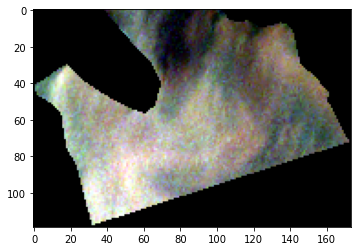

In [4]:
#Aca uso mapping (convierte a formato GeoJSON) y mask (para extraed datos)

#selecciono la geometría del primer ROI en formato shapely
roi0 = rois_shp['geometry'][0]
#y lo uso para extraer los valores de la imagen
with rasterio.open(raster_fn) as src:
     out_image, out_transform = mask(src, [roi0], crop=True)
     
show(nequalize(out_image[[2,1,0]],p=1))
plt.show()

In [5]:
type(out_image)

numpy.ndarray

In [6]:
out_image[:,0,0]

array([0., 0., 0., 0., 0.], dtype=float32)

### Haciendo que mask devuelva un array enmascarado con `filled=false`

In [7]:
with rasterio.open(raster_fn) as src:
     out_image, out_transform = mask(src, [roi0], crop=True, filled=False)

In [8]:
type(out_image)

numpy.ma.core.MaskedArray

In [9]:
out_image[:,0,0]

masked_array(data=[--, --, --, --, --],
             mask=[ True,  True,  True,  True,  True],
       fill_value=1e+20,
            dtype=float32)

In [10]:
out_image.data.shape


(5, 119, 174)

In [11]:
mascara = out_image.mask[0]

In [12]:
mascara

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [13]:
out_image.data[:,~mascara]

array([[ 0.0835    ,  0.0848    ,  0.0841    , ...,  0.0887    ,
         0.0884    ,  0.0878    ],
       [ 0.0605    ,  0.0608    ,  0.061     , ...,  0.07      ,
         0.0689    ,  0.0692    ],
       [ 0.0493    ,  0.0506    ,  0.0505    , ...,  0.0619    ,
         0.0587    ,  0.0588    ],
       [ 0.0401    ,  0.0397    ,  0.041     , ...,  0.049     ,
         0.0441    ,  0.0477    ],
       [-0.10290827, -0.12070873, -0.10382514, ..., -0.11632103,
        -0.14202332, -0.10422537]], dtype=float32)

## Armo un dataframe con los datos etiquetados
### 1. Leo el shp como geoDataFrame y veo las clases

In [14]:
# Leo los ROIS

#primero defino cantidad de atributos = cantidad de bandas en el raster
with rasterio.open(raster_fn) as src:
    d=src.count 

nodata=-255 #elijo un valor para nodata

#numero las clases de los ROIs alfabéticamente
clases=list(set(rois_shp['clase']))
clases

['agua', 'bosque', 'urbano', 'rural', 'humedal']

In [15]:
clases.sort()
clase_dict = {clase:i for i, clase in enumerate(clases)}
print(clase_dict)
print(clases)

{'agua': 0, 'bosque': 1, 'humedal': 2, 'rural': 3, 'urbano': 4}
['agua', 'bosque', 'humedal', 'rural', 'urbano']


In [16]:
clases[2]

'humedal'

In [17]:
clase_dict['humedal']

2

### 2. Armo dos arrays X y Y con datos y etiquetas

In [18]:
#Preparo colección de atributos etiquetados. Comienza con 0 datos
d,x,y = img.shape
d,x,y

(5, 960, 1280)

In [19]:
X = np.zeros([0,d],dtype = np.float32) #array con todos los atributos
Y = np.zeros([0],dtype=int)            #array con sus etiquetas

with rasterio.open(raster_fn) as src:
    for index, row in rois_shp.iterrows():
        geom_sh = row['geometry']
        clase = row['clase']
        clip, _transform = mask(src, [geom_sh], crop=True,nodata=nodata)
        d,x,y = clip.shape
        D = list(clip.reshape([d,x*y]).T) #rompo la estructura espacial, pero no espectral
        D = [p for p in D if (not (p==nodata).prod())]
        DX = np.array(D)        
        DY = np.repeat(clase_dict[clase],len(D))
        X = np.concatenate((X,DX))
        Y = np.concatenate((Y,DY))

### Así X tiene una fila por cada pixel (con sus datos espectrales) e Y tiene un elemento por cada pixel indicando la clase correspondiente.

In [20]:
#imprimo algunos datos etiquetados
R = 10 #cantindad a elegir al azar
N = len(Y)
N

47714

Ya no son puntos, sino, datos espectrales con etiqueta

ejemplo: 1 = bosque, 3 = rural

Cada columna tiene los datos espectrales de cada fila (cada fila es un pixel)

In [21]:
print('Algunos datos etiquetados:\n')
print('    Clase  Blue   Green  Red    NIR     NDVI')
for i in range(R):
    j = np.random.randint(N)
    print(f'{Y[j]:d}.{clases[Y[j]]:>7}: {X[j,0]:.3f}  {X[j,1]:.3f}  {X[j,2]:.3f}  {X[j,3]:.3f}  {X[j,4]: .3f}')

Algunos datos etiquetados:

    Clase  Blue   Green  Red    NIR     NDVI
2.humedal: 0.091  0.084  0.057  0.250   0.630
3.  rural: 0.094  0.099  0.061  0.372   0.717
0.   agua: 0.089  0.069  0.061  0.047  -0.133
1. bosque: 0.082  0.074  0.043  0.266   0.725
1. bosque: 0.085  0.080  0.046  0.254   0.694
4. urbano: 0.155  0.133  0.165  0.243   0.191
1. bosque: 0.086  0.072  0.046  0.196   0.618
3.  rural: 0.086  0.082  0.047  0.335   0.752
1. bosque: 0.084  0.074  0.044  0.238   0.690
3.  rural: 0.097  0.099  0.067  0.343   0.671


## Firmas espectrales

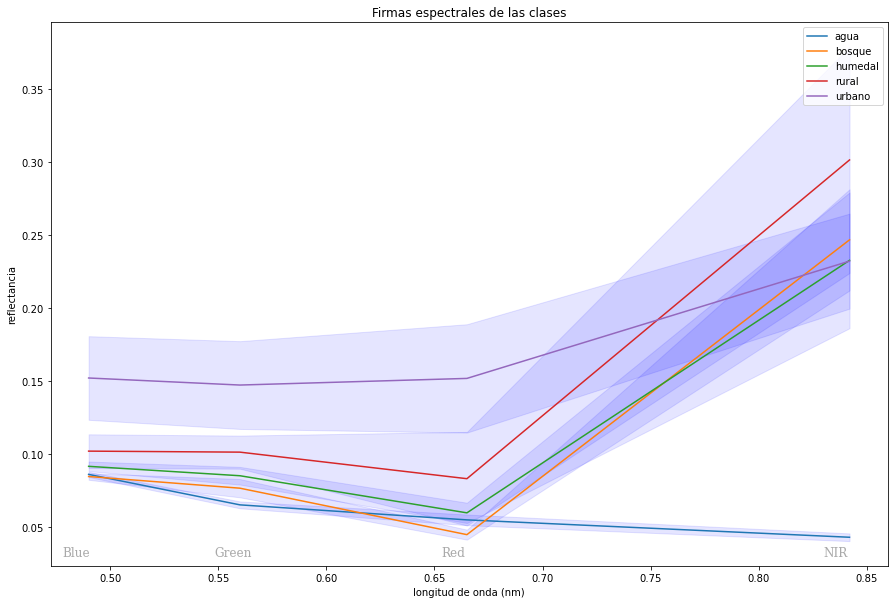

In [22]:
#%%
#Visualización
        
#Guardo las longitudes de onda para Sentiel2
B_G_R_NIR = [0.49,0.56, 0.665, 0.842]

#Armo la figura
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
for j,l in enumerate(clases):
    S = np.where(Y==j)[0]
    data_vis_clase = X[S,:-1] #tiro el NDVI pues no es espectral
    media_clase = data_vis_clase.mean(axis=0)
    std_clase = data_vis_clase.std(axis=0)
    ci = std_clase
    ax.plot(B_G_R_NIR,media_clase, label=l)
    ax.fill_between(B_G_R_NIR,media_clase-ci,(media_clase+ci), color='b', alpha=.1)
plt.ylim=[0,0.4]
plt.legend()
plt.xlabel("longitud de onda (nm)")
plt.ylabel("reflectancia")

plt.title('Firmas espectrales de las clases')
font = {'family':'serif', 'color':'darkgray', 'size':12}

for x,t in zip(B_G_R_NIR, ['Blue','Green','Red','NIR']):
    plt.text(x-0.012, 0.03, t, fontdict=font)

## Boxplots, Violinplots y Scatterplots

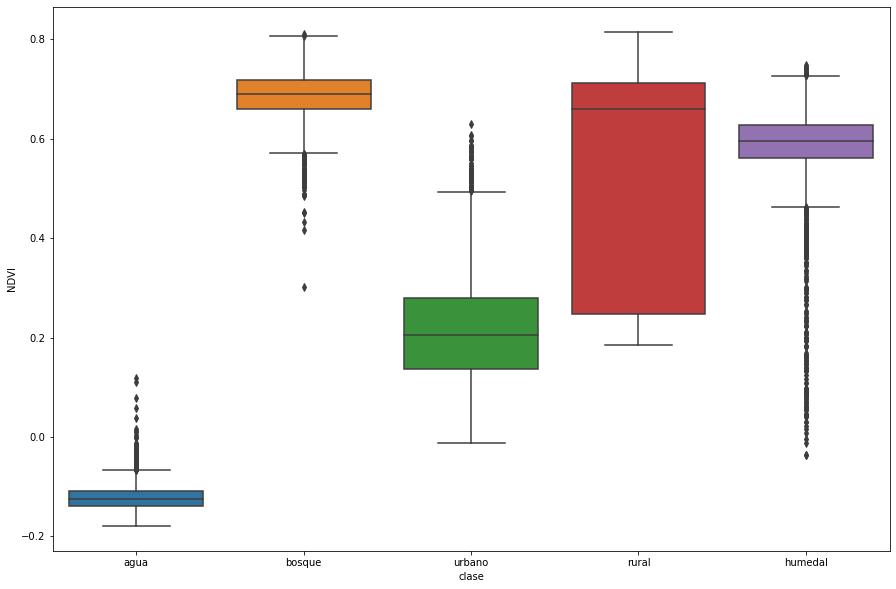

In [23]:
#Armo un dataframe con los datos etiquetados
data=pd.DataFrame({'B':X[:,0],'G':X[:,1],'R':X[:,2],'NIR':X[:,3],'NDVI':X[:,4],'clase':[clases[y] for y in Y]})

#y los grafico de diferentes formas
fig = plt.figure(figsize=(15,10))
sns.boxplot(data=data,x='clase', y='NDVI')
plt.show()

In [27]:
data

,B,G,R,NIR,NDVI,clase
0,0.0835,0.0605,0.0493,0.0401,-0.102908,agua
1,0.0848,0.0608,0.0506,0.0397,-0.120709,agua
2,0.0841,0.0610,0.0505,0.0410,-0.103825,agua
3,0.0836,0.0619,0.0503,0.0415,-0.095861,agua
4,0.0846,0.0624,0.0502,0.0421,-0.087757,agua
...,...,...,...,...,...,...
47709,0.1149,0.1100,0.1152,0.2155,0.303296,rural
47710,0.1281,0.1282,0.1483,0.2404,0.236944,rural
47711,0.1251,0.1239,0.1408,0.2290,0.238507,rural
47712,0.1157,0.1138,0.1241,0.2158,0.269785,rural


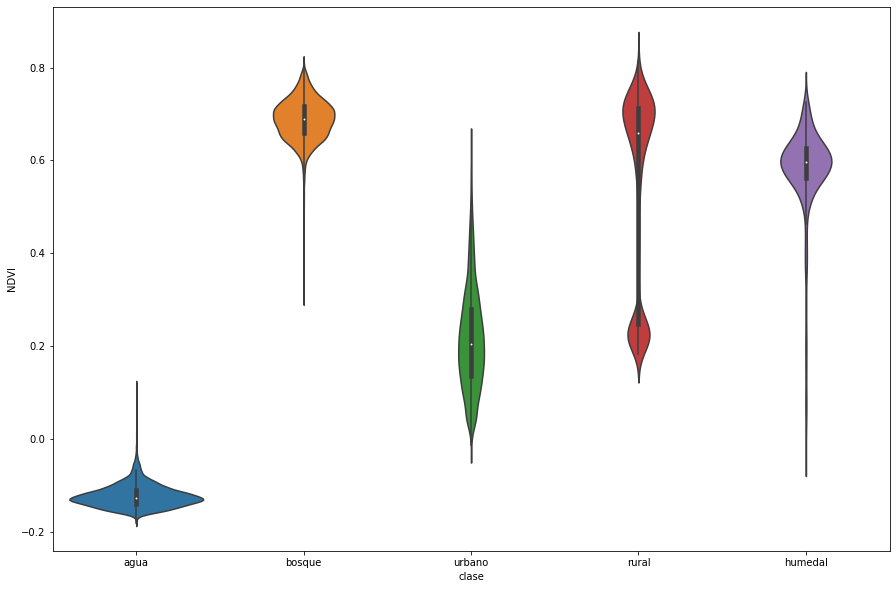

In [24]:
fig = plt.figure(figsize=(15,10))
sns.violinplot(data=data,x='clase', y='NDVI')
plt.show()

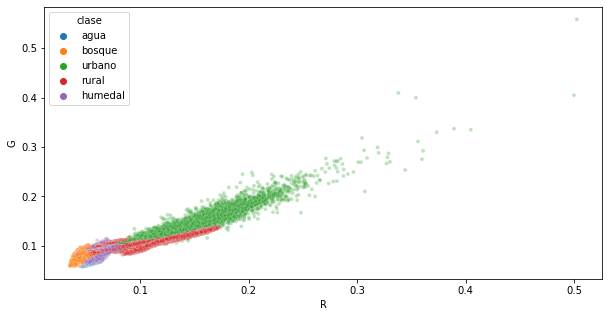

In [25]:
fig = plt.figure(figsize=(10,5))
sns.scatterplot(data=data, x='R', y='G',hue='clase', alpha=0.3, s=15)
plt.show()

### 9.1 Ejercicio de visualización de datos
1. Repetí el violinplot pero graficando solo para la clase _rural_
1. Repetí el scatterplot usando los ejes:
    1. Red y NIR
    1. NDVI y Blue
    1. NDVI y Green

### 9.2 Ejercicio de etiquetado
1. En los diferentes gráficos se observa que la clase _rural_ está compuesta de al menos dos clases mezcaldas. 
    1. Mirando tu último violin-plot, definí dos rangos de NDVI, correpondientes a potenciales clases diferentes.
    1. Generá una imagen que valga 1 dentro de un rango, 2 dentro del otro y 0 fuera de estos rangos. Ploteala incorporando los ROIs de la clase 'rural'
    1. Graficá la imagen RGB ecualizada delimitando, nuevamente, los ROIs rurales.
    1. Observando estas últimas dos imágenes tratá de entender a qué corresponden las dos subclases de 'rural'. Poneles nombre.
    1. Modificá el archivo _geoJSON_ usando (al menos dos) etiquetas diferentes según corresponda.
    1. Repetí los gráficos anteriores (firmas espectrales, violinplots, y scatterplots) con las nuevas etiquetas.
